### Colab Setup (skip in not in Colab)

- To speed up inference, go to "Runtime"->"Change runtime type" and select "GPU"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check if CUDA is installed 

In [2]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


### Setup
- Path for the folder that has the weights, cfg, obj, data...


In [3]:
path_setup = "/content/drive/MyDrive/"

Clone YOLIME repo

In [4]:
!git clone https://github.com/AntMorais/yolime

Cloning into 'yolime'...
remote: Enumerating objects: 14695, done.
remote: Total 14695 (delta 0), reused 0 (delta 0), pack-reused 14695
Receiving objects: 100% (14695/14695), 13.85 MiB | 1.95 MiB/s, done.
Resolving deltas: 100% (9982/9982), done.


Install [LIME](https://lime-ml.readthedocs.io/en/latest/).

In [5]:
!pip install lime

     |████████████████████████████████| 276kB 4.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=ebba7599d7b1fef49fb322976426fb16720096f0c0f4ff48750240ebf986253b
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


Make the project (this will generate the ```libdarknet.so``` shared object file which will be used by the darknet Python wrappers)

Example Makefile:
- opencv = 1
- gpu = 1
- cudnn = 1

In [6]:
%cd yolime
!make

/content/yolime
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DDEBUG -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -DDEBUG -Ofast -fopenmp -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DDEBUG -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -DDEBUG -Ofast -fopenmp -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘bool JSON_sender::write(const char*)’:
./src/http_stream.cpp:249:21: warning: unused variable ‘n’ [-Wunused-variable]
                 int n = _write(client, outputbuf, outlen);
                     ^
./src/http_stream.cpp: In function ‘void set_track_id(detection*, int, float, float, float, int, int, int)

Data Setup

In [7]:

%cd yolime
!cp /content/drive/MyDrive/YOLOv4/img_treino_mais_teste.zip ../
!unzip ../img_treino_mais_teste.zip -d ./data/
!cp /content/drive/MyDrive/YOLOv4/obj.names ./data
!cp /content/drive/MyDrive/YOLOv4/obj.data  ./data 
!cp /content/drive/MyDrive/YOLOv4/generate_train.py ./
!python generate_train.py

[Errno 2] No such file or directory: 'yolime'
/content/yolime
Archive:  ../img_treino_mais_teste.zip
   creating: ./data/obj/
  inflating: ./data/obj/20190515_091756.jpg  
 extracting: ./data/obj/20190515_091756.txt  
  inflating: ./data/obj/20190515_091809.jpg  
 extracting: ./data/obj/20190515_091809.txt  
  inflating: ./data/obj/20190515_091855.jpg  
 extracting: ./data/obj/20190515_091855.txt  
  inflating: ./data/obj/20190515_091902.jpg  
 extracting: ./data/obj/20190515_091902.txt  
  inflating: ./data/obj/20190515_091918.jpg  
 extracting: ./data/obj/20190515_091918.txt  
  inflating: ./data/obj/20190515_091923.jpg  
 extracting: ./data/obj/20190515_091923.txt  
  inflating: ./data/obj/20190515_092016.jpg  
 extracting: ./data/obj/20190515_092016.txt  
  inflating: ./data/obj/20190515_092022.jpg  
 extracting: ./data/obj/20190515_092022.txt  
  inflating: ./data/obj/20190515_092028.jpg  
 extracting: ./data/obj/20190515_092028.txt  
  inflating: ./data/obj/20190515_092248.jpg  


To select an image, write its relative path in data/train.txt.


```
data/obj/IMAGENAME.jpg
```

Example:

```
data/obj/20190515_113930.jpg
```



Every time we want to try a different image, run everything after this cell

In [8]:
import argparse
import os
import glob
import random
import time
import cv2
import numpy as np
import darknet
import darknet_images
from google.colab.patches import cv2_imshow

# No caso de querermos correr a rede default (para testar por ex.)
#txt_input = path_setup + "FIRELOC_DATA/train.txt"
#weights = path_setup + "FIRELOC_DATA/yolov4.weights"
#config_file = "cfg/yolov4.cfg"
#data_file = "cfg/coco.data"

# No caso de querermos a rede FireLoc
txt_input = "data/train.txt"
weights = path_setup + "FIRELOC_DATA/yolov4_treino_maisteste_5000.weights"

path_setup = "/content/drive/MyDrive/"
path_cfg = "/content/drive/MyDrive/YOLOv4/"
config_file = path_cfg + "yolov4_treino_416.cfg"
data_file = "data/obj.data"
# outras configurações
batch_size = True
dont_show = True
ext_output = True
save_labels = True
thresh = 0.25


images = darknet_images.load_images(txt_input)
image_name = images[0]
network, class_names, class_colors = darknet.load_network(
        config_file,
        data_file,
        weights,
        batch_size
)

# number of samples generated in explain_instance
num_samples = 1000
# max number of features to be used in the explanation (default is 100000)
num_features = 1000000



#---------------------------------------------------------------------------------------------

width = darknet.network_width(network)
height = darknet.network_height(network)
image = cv2.imread(image_name)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (width, height),
                            interpolation=cv2.INTER_LINEAR)



def grey_out(image, x, y, w, h):
    # input: ndarray returned by imread, height and width
    #Create an array of object rect which represents the region of interest
    rect = [[x-w/2,y+h/2], [x-w/2,y-h/2], [x+w/2,y-h/2],[x+w/2,y+h/2]]
    mask = np.array([rect], dtype=np.int32)

    #Create a new array filled with zeros, size equal to size of the image to be filtered
    image2 = np.zeros((width, height), np.int8)

    cv2.fillPoly(image2, [mask],255)    
    maskimage2 = cv2.inRange(image2, 1, 255)
    out = cv2.bitwise_and(image, image, mask=maskimage2)
    return out



def lime_classification_function(image_numpy):

    probabilities = np.zeros((len(image_numpy), len(class_names)))
    for i in range(len(image_numpy)):
        img = image_numpy[i]
        image, detections = darknet_images.image_detection_lime(
                img, network, class_names,
                class_colors, thresh
                )

        if save_labels:
            darknet_images.save_annotations(image_name, image, detections, class_names)
        if not dont_show:
            cv2.imshow('Inference', image)
            if cv2.waitKey() & 0xFF == ord('q'):
                return
        with open("probabilityArray.txt","r") as prob_array:
            lines = [float(line.rstrip()) for line in prob_array]
            probabilities[i] = lines
    return probabilities


# input:
# - class_name: string with name of class we want to explain (e.g. "Dog", "Smoke" ...)
# output:
# - picked_class: index for the bounding box with most confidence of the specified input class 
# - detections
def get_most_confident_bbox(class_name):
    image_original, detections = darknet_images.image_detection(
                image_name, network, class_names,
                class_colors, thresh
                )
    darknet.print_detections(detections, ext_output)
    #detections is a list of tuples (class, confidence,(coordinates))
    picked_class = -1
    for i in range(len(detections)):
        _tuple = detections[i]
        if _tuple[0] == class_name:
            coordinates = _tuple[2]
            with open("coordinates.txt","w") as coord_file:
                # we convert the coordinates to relative because that is how it is used in the C files
                coordinates_rel = darknet_images.convert2relative(image_original,coordinates)
                for _coord in coordinates_rel:
                    coord_file.write(str(_coord)+"\n")
                picked_class = i
    if picked_class == -1:
        print("There is no " + class_name + " in this image!")
    return picked_class, detections


In [9]:

class_name = 'Smoke'
picked_class, coordinates = get_most_confident_bbox(class_name)




Objects:
Fire: 27.8%    (left_x: 358   top_y:  410   width:   18   height:  12)
Smoke: 31.57%    (left_x: 360   top_y:  206   width:   98   height:  396)
Fire: 42.16%    (left_x: 20   top_y:  276   width:   29   height:  15)
Fire: 49.96%    (left_x: 68   top_y:  251   width:   28   height:  28)
Fire: 74.08%    (left_x: 149   top_y:  316   width:   21   height:  28)
Fire: 77.67%    (left_x: 116   top_y:  266   width:   33   height:  33)
Smoke: 82.11%    (left_x: 182   top_y:  153   width:   256   height:  303)


We remove everything from the image except the bounding box 

In [10]:
# pass the image, the height and width
greyed_out_image = grey_out(image_resized, coordinates[picked_class][2][0], coordinates[picked_class][2][1],\
                            coordinates[picked_class][2][2], coordinates[picked_class][2][3])

Run the following cell to see the resized image


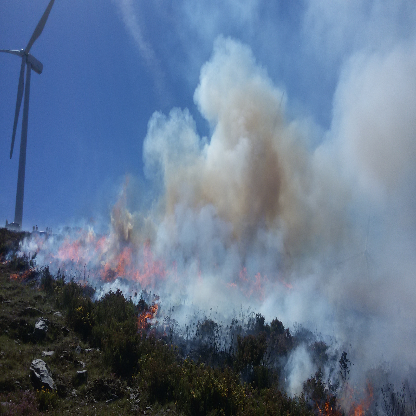

In [9]:
cv2_imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))

In [13]:
!python darknet_images.py --input data/train.txt --batch_size 64 --weights /content/drive/MyDrive/FIRELOC_DATA/yolov4_treino_maisteste_5000.weights --config_file /content/drive/MyDrive/YOLOv4/yolov4_treino_416.cfg --data_file data/obj.data 

 Try to load cfg: /content/drive/MyDrive/YOLOv4/yolov4_treino_416.cfg, weights: /content/drive/MyDrive/FIRELOC_DATA/yolov4_treino_maisteste_5000.weights, clear = 0 
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 64, batch = 2048, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 tcmalloc: large alloc 1417674752 bytes == 0x55b2d14d0000 @  0x7f300d77f001 0x7f300a71bef6 0x7f300a721e2c 0x7f300a77cecb 0x7f300a783791 0x7f300a787a12 0x7f300ad6fdae 0x7f300ad6f71f 0x7f300af835dc 0x7f300af82ab8 0x55b2ce4b57f2 0x55b2ce528d75 0x55b2ce523e0d 0x55b2ce4b677a 0x55b2ce52586a 0x55b2ce4b669a 0x55b2ce524a45 0x55b2ce523b0e 0x55b2ce523813 0x55b2ce5ed592 0x55b2ce5ed90d 0x55b2ce5ed7b6 0x55b2ce5c5103 0x55b2ce5c4dac 0x7f300c567bf7 0x55b2ce5c4c8a
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF

In [ ]:
from lime import lime_image
#Objeto do tipo LimeImageExplainer
explainer = lime_image.LimeImageExplainer()
#Objeto do tipo ImageExplanation
explanation = explainer.explain_instance(np.array(greyed_out_image), 
                                         lime_classification_function, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=num_samples,
                                         num_features=num_features) # number of images that will be sent to classification function

In [ ]:
# mostra a imagem que acabámos de detetar

import cv2
img = cv2.imread(image_name)
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))

In [ ]:


def show_bbox_centers(coordinates):

    import matplotlib.pyplot as plt
    #mostrar centros das bounding boxes 
    xx = []
    yy = []
    for class_coord in coordinates:
        xx.append(class_coord[2][0])
        yy.append(class_coord[2][1])
    plt.scatter(xx,\
            yy,\
            marker='o', color="red")
    
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],\
    positive_only=False, num_features=5\
    ,hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
show_bbox_centers(coordinates)
plt.show()

In [ ]:

def crop_img(img, new_filename, coordinates, picked_class):
    [center_x, center_y, width, height] = [coord for coord in coordinates[picked_class][2]]
    top_left_x = round(center_x - width/2)
    top_left_y = round(center_y - height/2)
    print(top_left_x)
    print(top_left_y)
    print(height)
    print(width)
    if top_left_x < 0:
        top_left_x = 0
    if top_left_y < 0:
        top_left_y = 0
    crop_img = img[top_left_y:top_left_y+round(height), top_left_x:top_left_x+round(width)]
    plt.imshow(crop_img)
    plt.show()
    # guardo a nova imagem num ficheiro
    cv2.imwrite(new_filename,crop_img)



crop_img(img_boundry2, "explanationHere.jpg", coordinates, picked_class)